# Loads the needed packages and reads the EMG data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from read_emg import *
import seaborn as sns
from IPython.display import Image
import seaborn as sns
import os

plt.style.use('seaborn-bright')
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.title_fontsize'] = 14
pd.options.display.float_format = "{:,.3f}".format
sns.set(font_scale=1.5)

In [2]:
### Reads the EMG data (healthy subjects)
df = pd.read_pickle('DataCollection.pkl')
df['Trial_num'] = df['Trial_num'].astype(int)

### Reads the EMG data (patients)
df_patient = pd.read_pickle('DataCollection_Patients.pkl')
df_patient['Trial_num'] = df_patient['Trial_num'].astype(int)

# Function that calculates the cross-correlation (Similarity)

In [3]:
Image(url= "Similarity.png", width=600, height=600)

In [4]:
### Calculating the similarity using the channel means
def cross_correlation_vector(A, B):
    A_vector = []
    B_vector = []
    for channel in range(0, 8):
        A_temp = A[:, channel] 
        A_channel_mean = A_temp.mean()
        A_vector.append(A_channel_mean)
        
        B_temp = B[:, channel]
        B_channel_mean = B_temp.mean()
        B_vector.append(B_channel_mean)
        
    A_vector = np.array(A_vector)
    B_vector = np.array(B_vector)
    C = np.multiply(A_vector, B_vector).sum() / (np.sqrt((A_vector**2).sum() * (B_vector**2).sum()))

    return C

# Function that flip the channels around ( 1 2 3 4 to 4 3 2 1)

In [5]:
def flipping_sensor(df_unflipped):
    A = df_unflipped.iloc[:, :8]
    A = A.loc[:, ::-1].values
    
    df_flipped = df_unflipped.copy()
    df_flipped.iloc[:, :8] = A
    
    return df_flipped

# Function that calculates the similarity between non-shifted and shifted channels

In [6]:
def CC_to_shift(df, subject_reference, subject_to_rotate, calibration_gesture, session_reference, session_to_rotate, plot = False):
    shift_list = []
    
    if plot == True:
        fig, ax = plt.subplots(3, 4, figsize = (21, 12))
        R = 0 
        Col = 0
        
    print(f'Current Subject: {subject_to_rotate}')
    df_A = df[(df['ID'] == subject_reference) & 
              (df['Gesture'] == calibration_gesture) & 
              (df['Trial_num'] == 3) & 
              (df['session'] == session_reference)].iloc[:, :8]
    df_A = df_A[df_A.index > 100]
    
    A_value = df_A.iloc[:, :8].rolling(1).mean().dropna().values

    shift_range = range(0, 8)

    max_CC = 0
    final_status = False
    final_shift = 0
    for flipped in [False, True]:
        if flipped == False:    
            df_B = df[(df['ID'] == subject_to_rotate) & 
                      (df['Gesture'] == calibration_gesture) & 
                      (df['Trial_num'] <= 3) & 
                      (df['session'] == session_to_rotate)].iloc[:, :8]
        else:
            print('Flipping the sensor\n')
            df_B = flipping_sensor(df[(df['ID'] == subject_to_rotate)  & 
                                      (df['Gesture'] == calibration_gesture) & 
                                      (df['Trial_num'] <= 3) & 
                                      (df['session'] == session_to_rotate)]).iloc[:, :8]
        
        df_B = df_B[df_B.index > 100]
        B = df_B.iloc[:, :8].rolling(1).mean().dropna()     
         
        CC_list = []
        for shift in shift_range:
            print(f'Shift: {shift}')

            B_value = pd.concat((B,B), axis = 1).iloc[:,  0 + shift:8 + shift].values

            C = cross_correlation_vector(A_value, B_value)
            print(f'CC: {C:.4f}\n')
            CC_list.append(C)
        try:
            shift_idx = np.where(CC_list == np.max(CC_list))[0][0]
            shift_list.append(shift_idx)

            if np.max(CC_list) > max_CC:
                max_CC = np.max(CC_list)
                final_status = flipped
                final_shift = shift_idx
                
        except Exception as e:
            print(e)

    print(f'\nFlipping needed? {final_status}\n')

    return final_status, shift_list


In [7]:
def shift_to_rotation(df, shift, subject_reference, subject_to_rotate, session_reference, session_to_rotate, flipped):
    df_train = df[(df['ID'] == subject_reference) & (df['session'] == session_reference) & (df['Trial_num'] <=3)]
        
    df_test = df[(df['ID'] == subject_to_rotate) & (df['session'] == session_to_rotate) & (df['Trial_num'] <=3)]
    

    df_test_temp = df_test.iloc[:, :8].copy()
    
    if flipped == True:
        df_test_temp = flipping_sensor(df_test.iloc[:, :8])
        df_test = flipping_sensor(df_test)
        
    df_test_calibrated = pd.concat((pd.concat((df_test_temp, df_test_temp), axis = 1).iloc[:,  0 + shift:8 + shift], df_test.iloc[:, 8:]), axis = 1)
    df_test_calibrated = pd.DataFrame(df_test_calibrated.values, columns = df_test.columns)
            
    return df_train, df_test, df_test_calibrated

# Calculates the similarity between gestures in every healthy subject and session


In [8]:
%%time

subject_list = list(df['ID'].unique())
gesture_list = ['2', '4', '5', '6', '7', '8', '9']
label_list = ['Cylinder Grasp', 'Wrist Extension', 'Fist', 'Finger mass extension', 'Opposition', 'Wrist / Finger extension', 'Lateral Pinch']
int_to_label = dict(zip(gesture_list, label_list))
stats = list()

for subject in ['0001', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1111', '1234', '9999'][:]:
    print('\n###############################')
    print(f'Current subject: {subject}')
    print('###############################\n')

        
    flipped, shift_list = CC_to_shift(df, 
                        subject_reference = subject, 
                        subject_to_rotate = subject, 
                        calibration_gesture = '8', 
                        session_reference = 'S1', 
                        session_to_rotate = 'S2')
    flipped = False
    
    if flipped == False:
        shift = shift_list[0]
    else:
        shift = shift_list[1]    
        
    
    df_reference_S1, df_original_S2, df_calibrated_S2 = shift_to_rotation(df, shift, 
                                                                 subject_reference = subject, 
                                                                 subject_to_rotate = subject,
                                                                 session_reference = 'S1', 
                                                                 session_to_rotate = 'S2', 
                                                                 flipped = flipped)
    print('Gesutre: Cross-correlation')
    ### Nested for-loop (brute force)
    for gesture_A in gesture_list:
        
        for gesture_B in gesture_list:
            
            df_S1_gesture_A = df_reference_S1[(df_reference_S1['Gesture'] == gesture_A)]
            df_S1_gesture_B = df_reference_S1[(df_reference_S1['Gesture'] == gesture_B)]

            A_S1 = df_S1_gesture_A.iloc[:, :8].values
            B_S1 = df_S1_gesture_B.iloc[:, :8].values

            C_S1 = cross_correlation_vector(A_S1, B_S1)
            
            df_S2_gesture_A = df_calibrated_S2[(df_calibrated_S2['Gesture'] == gesture_A)]
            df_S2_gesture_B = df_calibrated_S2[(df_calibrated_S2['Gesture'] == gesture_B)]

            A_S2 = df_S2_gesture_A.iloc[:, :8].values
            B_S2 = df_S2_gesture_B.iloc[:, :8].values

            C_S2 = cross_correlation_vector(A_S2, B_S2)
            
#             print(f'S1: {int_to_label[gesture_A]} and {int_to_label[gesture_B]}: {C_S1:.2f}')
#             print(f'S2: {int_to_label[gesture_A]} and {int_to_label[gesture_B]}: {C_S2:.2f}')
            stats.append({'ID':subject,
                          'shift': shift,
                          'GestureA': int_to_label[gesture_A],
                          'GestureB': int_to_label[gesture_B],
                          'CC_S1': C_S1,
                          'CC_S2':C_S2})


###############################
Current subject: 0001
###############################

Current Subject: 0001
Shift: 0
CC: 0.9715

Shift: 1
CC: 0.7388

Shift: 2
CC: 0.5122

Shift: 3
CC: 0.4212

Shift: 4
CC: 0.4447

Shift: 5
CC: 0.4945

Shift: 6
CC: 0.6411

Shift: 7
CC: 0.9052

Flipping the sensor

Shift: 0
CC: 0.8063

Shift: 1
CC: 0.9688

Shift: 2
CC: 0.8307

Shift: 3
CC: 0.6516

Shift: 4
CC: 0.5569

Shift: 5
CC: 0.4277

Shift: 6
CC: 0.3659

Shift: 7
CC: 0.5214


Flipping needed? False

Gesutre: Cross-correlation

###############################
Current subject: 1001
###############################

Current Subject: 1001
Shift: 0
CC: 0.9891

Shift: 1
CC: 0.8739

Shift: 2
CC: 0.7205

Shift: 3
CC: 0.6018

Shift: 4
CC: 0.5816

Shift: 5
CC: 0.6767

Shift: 6
CC: 0.8382

Shift: 7
CC: 0.9627

Flipping the sensor

Shift: 0
CC: 0.8408

Shift: 1
CC: 0.9768

Shift: 2
CC: 0.9769

Shift: 3
CC: 0.8703

Shift: 4
CC: 0.7127

Shift: 5
CC: 0.5962

Shift: 6
CC: 0.5846

Shift: 7
CC: 0.6861


Flipping need

In [9]:
stats = pd.DataFrame(stats).set_index('ID')

In [10]:
gesture_list = stats['GestureA'].unique()
matrix_df = stats.groupby(['GestureA', 'GestureB']).mean().iloc[:, 1:]
index = matrix_df.index
correlation_df = pd.DataFrame(None, columns = gesture_list, index = gesture_list)

In [11]:
for idx in index:
    GestureA = idx[0]
    GestureB = idx[1]
    correlation_df.loc[GestureA, GestureB] = matrix_df.loc[idx, :].mean()

# Calculates the similarity between gestures in every patient and session

In [13]:
%%time

subject_list = list(df_patient['ID'].unique())
gesture_list = ['2', '4', '5', '6', '7', '8', '9']
label_list = ['Cylinder Grasp', 'Wrist Extension', 'Fist', 'Finger mass extension', 'Opposition', 'Wrist / Finger extension', 'Lateral Pinch']
int_to_label = dict(zip(gesture_list, label_list))
stats_patient = list()

for subject in ['0001', '0002', '0003', '0004']:
    print('\n###############################')
    print(f'Current subject: {subject}')
    print('###############################\n')
    
    df_reference_S1 = df_patient[(df_patient['ID'] == subject) & (df_patient['Trial_num'] <= 3)]
    df_reference_S1 = df_reference_S1[df_reference_S1.index > 100]

    print('Calculating correlation between gestures')
    ### Nested for-loop (brute force)
    for gesture_A in gesture_list:
        
        for gesture_B in gesture_list:
            
            df_S1_gesture_A = df_reference_S1[(df_reference_S1['Gesture'] == gesture_A)]
            df_S1_gesture_B = df_reference_S1[(df_reference_S1['Gesture'] == gesture_B)]

            A_S1 = df_S1_gesture_A.iloc[:, :8].values
            B_S1 = df_S1_gesture_B.iloc[:, :8].values

            C_S1 = cross_correlation_vector(A_S1, B_S1)
            
#             print(f'S1: {int_to_label[gesture_A]} and {int_to_label[gesture_B]}: {C_S1:.2f}')
#             print(f'S2: {int_to_label[gesture_A]} and {int_to_label[gesture_B]}: {C_S2:.2f}')
            stats_patient.append({'ID':subject,
                          'GestureA': int_to_label[gesture_A],
                          'GestureB': int_to_label[gesture_B],
                          'CC_S1': C_S1})


###############################
Current subject: 0001
###############################

Calculating correlation between gestures

###############################
Current subject: 0002
###############################

Calculating correlation between gestures

###############################
Current subject: 0003
###############################

Calculating correlation between gestures

###############################
Current subject: 0004
###############################

Calculating correlation between gestures
Wall time: 1.03 s


In [14]:
stats_patient = pd.DataFrame(stats_patient).set_index('ID')

In [15]:
gesture_list = stats_patient['GestureA'].unique()
matrix_df = stats_patient.groupby(['GestureA', 'GestureB']).mean().iloc[:, 0:]
index = matrix_df.index
correlation_df_patient = pd.DataFrame(None, columns = gesture_list, index = gesture_list)

In [16]:
for idx in index:
    GestureA = idx[0]
    GestureB = idx[1]
    correlation_df_patient.loc[GestureA, GestureB] = matrix_df.loc[idx, :].mean()

# Gesture corelation matrix (Healthy and  Patient)

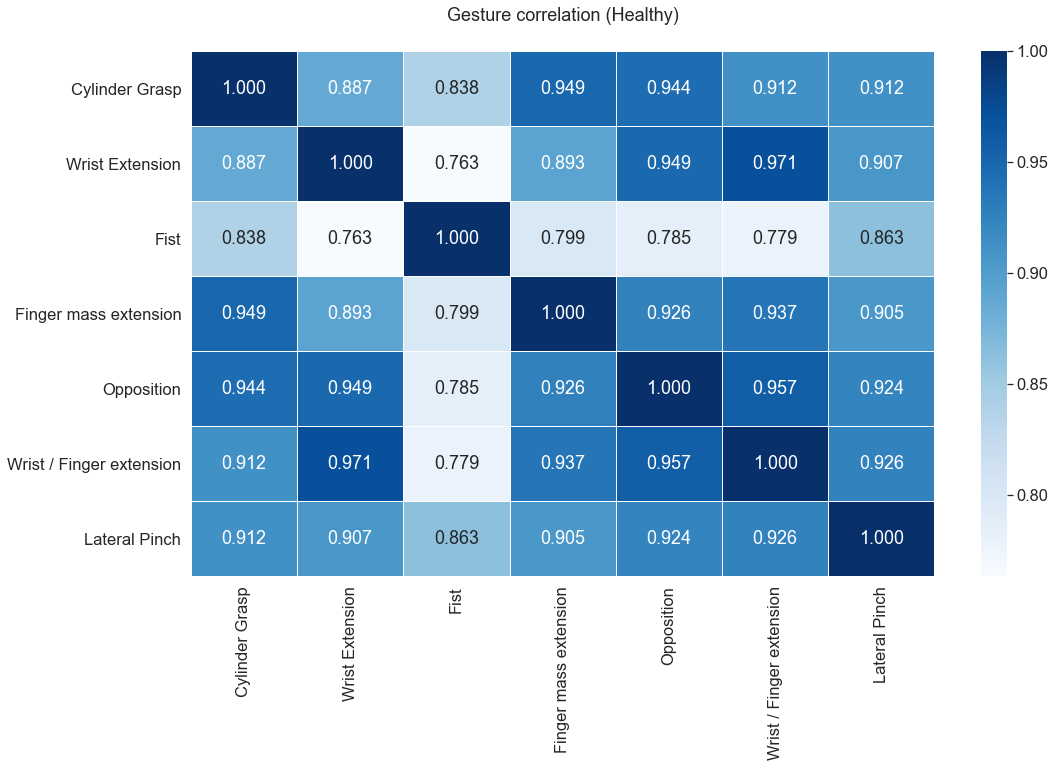

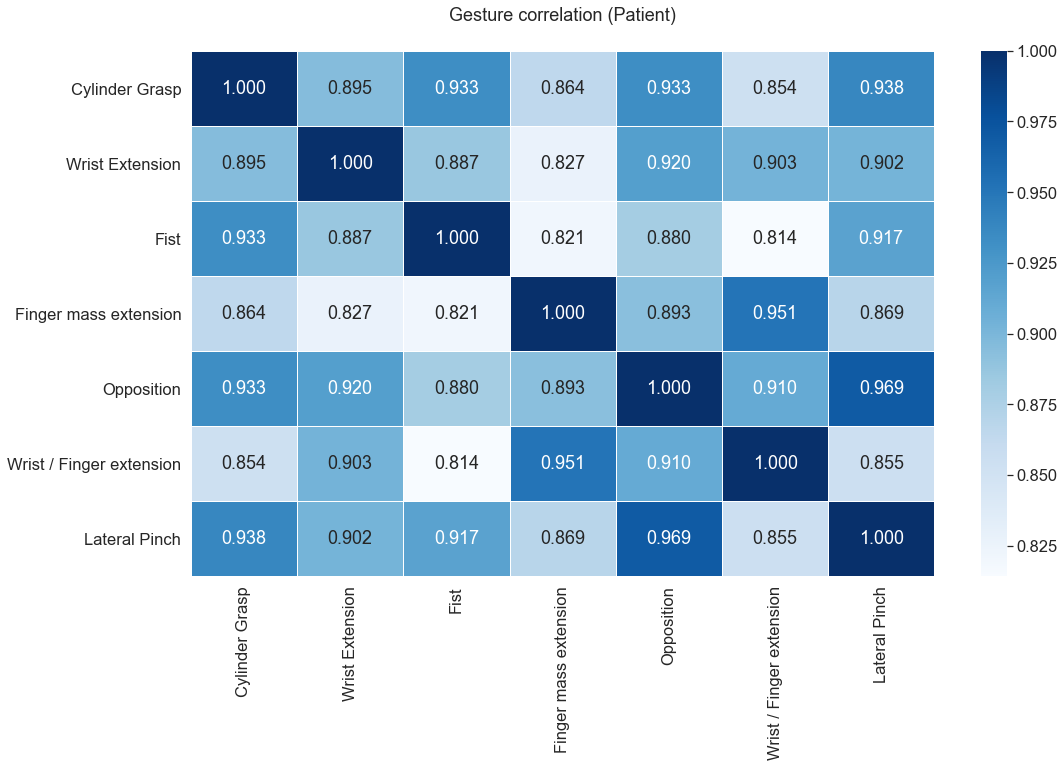

In [19]:
plt.figure(figsize = (16, 11))
sns.heatmap(correlation_df.astype('float'), cmap = 'Blues', annot=True, fmt=".3f", linewidths=1.0)
if os.path.exists('Correlation_matrix/') == False:
    os.mkdir('Correlation_matrix')
    
plt.title('Gesture correlation (Healthy)', pad = 30)    
plt.tight_layout()
plt.savefig('Correlation_matrix/Correlation_matrix.png')

plt.figure(figsize = (16, 11))
sns.heatmap(correlation_df_patient.astype('float'), cmap = 'Blues', annot=True, fmt=".3f", linewidths=1.0)
plt.title('Gesture correlation (Patient)', pad = 30)
plt.tight_layout()

if os.path.exists('Correlation_matrix/') == False:
    os.mkdir('Correlation_matrix')
    
plt.savefig('Correlation_matrix/Correlation_matrix_patient.png')